# Analyse et Exploration des données S7 : Régression logistique (exercice)

- Année 2025/2026
- Jean Delpech
- Classe : B3 IA/Data (Campus Aix-en-Provence)
- Dernière mise à jour : janvier 2026


Nous faisons une présentation théorique très rapide, et donc très incomplète, les détails étant vus en cours de math.

## Aperçu théorique rapide

La régression linéaire vu précédemment modèlise, comme son nom l’indique, des relations entre variables selon une relation linéaire (de proportionalité) pour expliquer la variance d’une variable par d’autres.

Techniquement, elle met en relation des variables quantitatives (numériques). Théoriquement, même si en général les variables observées ont des domaines d’existences bornés, elle peut mettre en relation deux variables ou plus qui varient entre -∞ et +∞ :

$$ x \in ]-\infty ; +\infty[ \longrightarrow y \in ]-\infty ; +\infty[ $$ 

![Domaine de définition droite de régression](./images/DroiteDomaineDef.png)

Nous avons vu que nous pouvions utiliser des variables catégorielles en tant que variables explicatives dans la régression linéaire, en encodant chaque catégorie avec une variable binaire (dont les valeurs sont soit 0 soit 1).

Mais pourrait-on encoder une variable catégorielle que l’on cherche à prédire, par un encodage binaire, et prédire le résultat par une régression ? 

Comme les valeurs à prédire seraient 0 ou 1, même en considérant une continuité de 0 à 1, la régression linéaire prédisant un résultat allant de -∞ à +∞, cela ne fonctionne pas vraiment. De plus les données binaires ne respectent pas la condition d’égalité des variances (cf. le cours précédent et le modèle `sex` -> `tip`).

Il faudrait trouver une fonction continue sur \[0 ; 1\] et définie sur ]-∞ ; +∞[. Pour faire simple, c’est le cas de la fonction sigmoïde dont la définition est :

$$ f(x)=\frac{1}{1+e^{-(\alpha + \beta x)}} $$

Les plus observateurs reconnaîtront au niveau de l’exponentielle une formule linéaire… cette fonction est donc une transformation de l’équation de régression en une fonction sur ]0 ; 1[ ce qui est notre objectif :

In [2]:
import numpy as np
import matplotlib.pyplot as plt

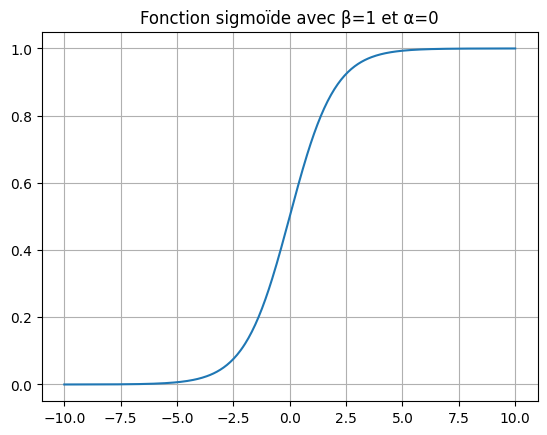

In [5]:
# Définition de la fonction sigmoïde
def sigmoid(x, b=1, a=0):
    return 1 / (1 + np.exp(-b*x - a))

# Génération des valeurs de x
x = np.linspace(-10, 10, 400)
plt.plot(x, sigmoid(x))
plt.title('Fonction sigmoïde avec β=1 et α=0')
plt.grid();

Quel rôle jouent les coefficient ou paramètres *β* et *α* ?

* *α* est l’offset de la fonction (décalage vers la gauche ou la droite selon le signe de *α*)
* *β* est « l’inclinaison » de la « pente » de la courbe
* 
Créons un petit script qui fait varier ces paramètres et permet de le constater :

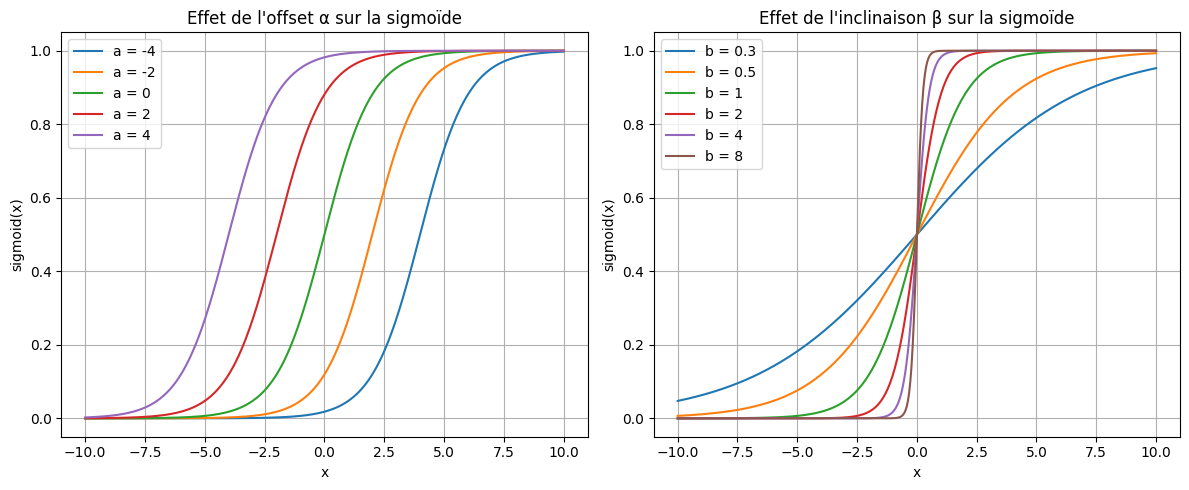

In [6]:

# Variations de l'offset a
a_values = [-4, -2, 0, 2, 4]
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for a in a_values:
    plt.plot(x, sigmoid(x, a=a), label=f"a = {a}")
plt.title("Effet de l'offset α sur la sigmoïde")
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.legend()
plt.grid()

# Variations du facteur d'inclinaison b
b_values = [0.3, 0.5, 1, 2, 4, 8]
plt.subplot(1, 2, 2)
for b in b_values:
    plt.plot(x, sigmoid(x, b=b), label=f"b = {b}")
plt.title("Effet de l'inclinaison β sur la sigmoïde")
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Note : une valeur négative de *β* conduirait à une « inversion » de la courbe (irait de « 1 à 0 » et non de « 0 à 1 »)

Si la fonction est continue et prend les valeurs entre 0 et 1, comment l’utiliser pour prédire une variable catégorielle ?

En fait la fonction va représenter la *probabilité* selon le modèle que la variable expliquée appartienne à une catégorie (p.-ex. 0) ou l’autre (1). Pour créer un classificateur binaire à partir de ces probabilités continues, on va fixer un seuil au-delà (et en-dessous) duquel la valeur prédite va tomber dans une catégorie, ou l’autre :

![Seuil de classification sur la sigmoïde](./images/ClassificationThreeshold.png)

Par rapport à la pente, ce seuil défini deux zones (une valeur limite de x) où les points seront classifiés comme appartenant à une catégorie ou une autre :

![Seuil de classification sur la sigmoïde](./images/ClassificationThreesholdZones.png)

On constate l’existence d’une zone de « recouvrement » ou par rapport aux données réelles, il peut y avoir des erreurs de classification. En effet selon la raideur de la pente, cette zone peut-être plus ou moins large. En effet, si pour un x donné on a une probabilité de 80%, cela signifie qu’avec le seuil tout ces points seront classé comme dans la catégorie 1, et donc il y aura 20% d’erreur.

Comment évaluer la qualité du modèle ? C’est important pour savoir comment estimer les paramètres *β* et *α*.

Les valeurs observées seront de la forme : \[0 ; 1 ; 0 ; 0 ; 0 ; 1 ; 1…\] (soit 0, soit 1).
Les valeurs prédites seront de la forme : \[0.8324 ; 0.25324 ; 0.18765 ; 0.95434 ; 0.763654…\], *jamais* égales à 0 ou 1.
On veut donc avoir une valeur prédite la plus proche de 1 quand la valeur observée est égale à 1, et avoir une valeur prédite proche de 0 quand quand la valeur observée est égale à 0. Malheureusement, cela rend compliquée l’utilisation d’une méthode de moindres carrés : si les valeurs observées sont justes 0 et 1, l’erreur quadratique (y<sub>observée</sub> - y<sub>prédite</sub>)<sup>2</sup> va toujour être proche de 0, et donc risque d’instabilité au cours de l’optimisation, d’autant qu’on va chercher à *minimiser* cette grandeur. De plus la fonction sigmoïde n’est pas linéaire (c’est pour cela qu’on l’a choisie) ce qui complique encore les choses.

La solution au contraire va être de chercher à maximiser une grandeur en remarquant que : 
* y<sub>prédite</sub> doit être proche de 1 quand y<sub>observée</sub> est égale à 1 (rien de changé)
* (1 - y<sub>prédite</sub>) doit être proche de 1 quand y<sub>observée</sub> est égale à  0 !!

On va appeler cela le *maximum de vraisemblance* ou **Likelihood**. On va la définir comme les produits de  (1 - y<sub>prédite</sub>) quand l’observation est égale à 0 par les y<sub>prédite</sub> quand l’observation est égale à 1. Plus formellement la fonction de vraisemblance pour une régression logistique est donnée par :
$$ \mathcal{L()} = \prod_{i=1}^{n} \hat{y}_i^{y_i} (1 - \hat{y}_i)^{1 - y_i} $$

Cette fonction si elle permet de mieux gérer les variables binaires, est très sensible aux erreurs : c’est un produit donc la moindre prédiction proche de 0 (probabilité de 0 là où on devrait avoir une observation égale à 1 et 1-probabilité proche de 0 là où on devrait avoir 1 - 0) fait drastiquement baisser l’ensemble de la likelihood (que l’on veut maximiser).

On ne va pas rentrer dans les détails dans ce cours très appliqué, mais il est dommage d’aborder la régression logistique sans exposer les notions de *logit* ou *log-odds*, qui permette de comprendre comment on passe d’une équation de régression à une sigmoïde.
Voir ces liens :

https://en.wikipedia.org/wiki/Logit

https://www.youtube.com/watch?v=yIYKR4sgzI8

Un mot sur les « *odds* ». Il s’agit simplement du ration entre la probabilité qu’un évènement survienne sur la probabilité qu’il ne survienne pas :

$$ odds = \frac{p}{1-p} $$

Par exemple si on a 80% de chance de survivre : 
* proba survie = 0.8
* proba de ne pas survivre = 1 - 0.8 = 0.2
* odds : 0.8 / 0.2 = 4 -> odds de « 4 contre 1 » 

Et en fait les paramètres de la régression logistiques sont des log-odds, le logarithme d’un odd :

$$ \ln{\frac{p}{1-p}} $$

On appelle cette fonction *logit*, avec $\text{logit p} = \ln{\frac{p}{1-p}} $. Par ailleurs, cette fonction $\text{logit}$ est tout simplement l’inverse de la fonction sigmoïde !

![Passage de l’espace des log-odds à l’espace des probabilités](./images/EspaceLogOdds.png)

Il n’est donc pas inutile de faire quelques rappels sur la fonction logarithme :

$$ n = \log_b(x) \Longleftrightarrow x=b^n $$

* *n* est appelé *exposant*
* *b* est appelé *base*

Pour une base *b*, lorsque *n* augmente de 1, *log<sub>b</sub>* augmente de 1. Ainsi, pour une base 10 (par convention *log()* sans précision est de base 10) :

* *log*(10) = 1
* log*(100) = 2
* log*(1000) = 3
* etc.

Pour une base 2 :

* *log<sub>2</sub>(2)* = 1
* *log<sub>2</sub>(4)* = 2
* *log<sub>2</sub>(8)* = 3 
* *log<sub>2</sub>(16)* = 4
* *log<sub>2</sub>(1/2)* = -1

En termes de notation : *log<sub>e</sub>()* est notée* ln()*. Dans numpy `np.log()` est la fonction *ln()* et `np.log10()` est la fonction *log()*. 

La fonction *ln()* est définie sur l’intervalle :

$$ \forall x \in \mathbb{R}_+^* : \ln(x) \in ]-\infty ; +\infty[$$

## Ressources

[Une excellente playlist d’introduction à la régression logistique par StatQuest](https://www.youtube.com/playlist?list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe) :
* [Introduction à la régression logistique](https://www.youtube.com/watch?v=yIYKR4sgzI8)
* [Odds et log(odds)](https://www.youtube.com/watch?v=ARfXDSkQf1Y)
* [Odds ratio et log(odds ratio)](https://www.youtube.com/watch?v=8nm0G-1uJzA)
* [Les paramètres de la régression logistique](https://www.youtube.com/watch?v=vN5cNN2-HWE)
* [Le maximum likelihood](https://www.youtube.com/watch?v=BfKanl1aSG0)
* [$R^2$ et p-value pour la régression logistique](https://www.youtube.com/watch?v=xxFYro8QuXA)

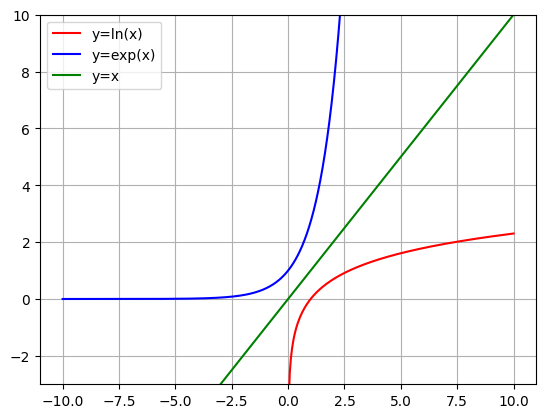

In [7]:
plt.plot(x[x>0], np.log(x[x>0]), c='r', label='y=ln(x)') # attention au warning pour les x =< 0
plt.plot(x, np.exp(x), c='b', label='y=exp(x)')
plt.plot(x,x, c='g', label='y=x')
plt.ylim(-3, 10)
plt.legend()
plt.grid();

## Régression logistique en pratique

Chargeons les données `Titanic` de `seaborn` (le grand classique pour étudier la régression logistique)

In [1]:
import seaborn as sns

In [2]:
titanic_df = sns.load_dataset('titanic')
titanic_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### Bases

Le but du jeu va être de créer un modèle qui prédit les chances de survie des passagers.
Élaborons un modèle de régression logistique le plus simple, réduit au paramètre α :

In [3]:
import statsmodels.formula.api as smf

In [30]:
simplest_model = smf.logit(formula='survived ~ 1', data=titanic_df)
simplest_result = simplest_model.fit()
simplest_result.params

Optimization terminated successfully.
         Current function value: 0.665912
         Iterations 4


Intercept   -0.473288
dtype: float64

In [37]:
odds_survived = np.exp(simplest_result.params.iloc[0])
print(odds_survived)

0.6229508196721313


N’oublions pas que l’intercept $\alpha$ est l’ordonnée à l’origine dans l’espace des $\log odds$ elle exprime donc elle-même un $\log odds$, pour l’interpréter comme une probabilité il faut d’une part « enlever » le $\log$ avec une exponentielle, et d’autre part recalculer $p$ à partir de la formule $odds = \frac{p}{1-p}$ :

$$ odds = \frac{p}{1-p} = \exp{-0,473288} = 0,6229508… $$ 
$$ p = (1-p).0,62… $$
$$ p = 0,62… -p.0,62 $$
$$ p + p.0,62… = 0,62… $$
$$ p.(1 + 0,62…) = 0,62… $$
$$p =  \frac{0,62…}{1+0,62…}$$

In [39]:
print(odds_survived/(1 + odds_survived))

0.38383838383838387


On peut obtenir ce résultat directement :

In [40]:
titanic_df['survived'].mean()

np.float64(0.3838383838383838)

En style pandas :

In [43]:
import pandas as pd

In [45]:
pd.DataFrame({
    'percentage': titanic_df['survived'].value_counts(normalize=True).round(2)
})

,percentage
survived,
0,0.62
1,0.38


Créons un modèle avec au moins une variable :

In [46]:
age_model = smf.logit(formula='survived ~ age', data=titanic_df)
age_result = age_model.fit()
age_result.params

Optimization terminated successfully.
         Current function value: 0.672429
         Iterations 4


Intercept   -0.056724
age         -0.010963
dtype: float64

L’interprétation est la même que pour une régresssion : avec un an de plus, les chances (!!! **log odds** !!!) de survie *baissent* de -0.01. On ne peut pas interpréter $\beta$ qui produit une évolution non linéaire de la probabilité de survivre de la même manière qu’$\alpha$ qui, étant une constante, peut être vue comme une probabilité de base (de survivre). 

Il faut calculer les odds et les probabilités à la main. Quelle est votre interprétation des paramètres ? Avec vos propres termes, comment l’âge influence la chance de survie ? À vous de jouer.

In [ ]:
# votre code ici



Faites de même avec la variable `Fare` (tarif) :

In [3]:
# votre code ici


Dans ce dernier cas, comment interpréteriez-vous l’intercept de la régression logistique ?

**< votre réponse ici >**


### Variables catégorielles

Comment gère-t-on les variables catégorielles ?

Exactement comme nous avons vu pour la régression linéaire ! Essayez, avec `patsy`, pour la variable `class` et voir comment elle affecte la survie. Attention, 'class' est un mot-clé qui provoque une erreur de syntaxe dans `patsy`, il faut renommer la colonne :

In [ ]:
titanic_df = titanic_df.rename(columns={'class': 'class_renamed'})

In [ ]:
# votre code ici



Interprétez ces paramètres.

**< votre réponse ici >**

Les odds de survie sont divisées par combien entre la 2e et la 1ère classe, et entre la 3e et la 1ère classe ?

Pour répondre à cette question rappelez-vous :

Pour savoir par combien les odds sont divisées en passant de la 1ère et la seconde classe, il faut calculer :

$$ \frac{odds_{1^{ère} classe}}{odds_{2^{ème} classe}} = \exp{\ln{\frac{odds_{1^{ère} classe}}{odds_{2^{ème} classe}}}}$$

or le paramètre `C(class_renamed)[T. Second]` indique la différence ln(*odds<sub>2ème classe</sub>*) - ln(*odds<sub>1ère classe</sub>*)

on peut donc calculer le premier ratio grâce à la formule :

$$ \ln{\frac{a}{b}} = \ln{a} - \ln{b} $$

Il faut donc dans un premier temps calculer :

$$ \ln{odds_{1^{ère} classe}} - \ln{odds_{2^{ème} classe}} $$

(attention au sens du ratio et de la différence !)

puis calculer l’exponentielle de cette différence.

In [ ]:
# votre code ici



**< vos commentaires ici : « les odds de survivre en deuxième classe sont divisées par … comparés à la 1ère classe.>**

Enfin créez un modèle qui prédit la survie avec les trois variables que nous avons déjà vu. Comment interpréteriez vous les paramètres obtenus ? N’oubliez pas que dans un modèle multivarié on compare toujours « toutes choses égales par ailleur »

In [48]:
# votre code ici


**< votre interpétation des paramètres ici >**

### Qualité du modèle

Générez les indices qui permettent un premier diagnostic du modèle :

In [49]:
# votre code ici



Ici on ne peut pas utiliser le *t* de Student, on a affaire à des probabilités. On va pouvoir utiliser un z-score (écart à la moyenne) car le fait de réaliser un tirage aléatoire (indépendant) d’une variable binaire correspond au [processus de Bernouilli](https://fr.wikipedia.org/wiki/Processus_de_Bernoulli), dont on connait la moyenne et la distribution théorique. Rappel : on utilise un *t*-test quand on ne connait pas la dispertion (σ) de la population, et un *z*-test quand on la connait.

Par contre, quelle grandeur va bien pouvoir remplacer *R<sup>2</sup>* ?

Quels sont les indices qui apparaissent dans le tableau et semblent jouer le même rôle ?

In [ ]:
< votre réponse ici >

























#### Log-likelihood

Il faut comprendre cette notion avant de présenter le « pseudo-*R<sup>2</sup>*. Heureusement c’est très simple. 

D’ailleurs, d’après le nom, qu’est-ce que ça peut être ?

**< votre réponse ici >**

Quelle est la valeur maximale de la likelihood ? Minimale ?

**< votre réponse ici >**

Dans quel intervalle se situe donc la log-likelihood ?

**< votre réponse ici >**

Partant de là, quelle est la valeur de la log-likelihood pour un modèle idéal (parfait) ?

**< votre réponse ici >**

Formule de la log-likelihood :
$$ \log(\mathcal{L}) = \sum_{i=1}^{n} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right] $$ 

#### Pseudo-R<sup>2</sup> 

Il est définit de manière analogue au *R<sup>2</sup>* de la régression multivariée, mais avec la Log-Likelihood (LL) plutôt que les sommes de carrés.

**< votre formule ici >**

Quelles valeurs peut-il prendre ?

**< votre réponse ici >**

Mais il est un peu plus limité. Il ne dit rien sur la qualité du modèle dans l’absolu. Il permet juste de comparer deux modèles entre eux. En fait la qualité du modèle (les erreurs) tiennent beaucoup au seuil que l’on va fixer…

#### Classification et métriques

Il y a différentes métriques qui existent pour mesurer la performance d’un modèle en classification, qui vont s’articuler autour d’une matrice de confusion (ici un modèle qui doit classer fleurs / non-fleurs) :

![matrice de confusion](./images/MatriceConfusion.png)

* accuracy (exactitude) : proportion de prédiction correctes (vrais négatifs, et vrais positifs). Problème, s’il y a peu de vrais négatifs, il suffit de dire tout le temps que les images sont des positifs pour que le classificateur ait de bonnes performances (pas de sanctions si erreurs type faux positifs ou faux négatif)

* precision (précision) :

$$ précision = \frac{VP}{VP + FP} $$

* recall (rappel ou sensibilité)

$$ rappel = \frac{VP}{VP + FN} $$

* F1 (moyenne harmonique de la précision et du rappel)

$$ F_{1} = \frac{1}{\frac{1}{précision} + \frac{1}{rappel}} = \frac{VP}{VP + \frac{FN + FP}{2}} $$

Calculer les différents score pour la matrice de confusion donnée en exemple.

Essayer de calculer aussi pour les modèles de régression logistique que vous créerez. Essayer de faire le meilleur prédicteur de la survie !

In [51]:
# votre code ici



Enfin, maintenant que vous savez apprécier la qualité des modèles, essayez de construire le modèle qui explique le mieux la survie des passagers du titanic. N’hésitez pas à faire un peu d’exploration de données avec de la dataviz pour identifier les variables dignes d’intérêt.

In [ ]:
# votre code ici

